# 1. 원본 데이터 1:1 증강 + YOLO 모델로 얼굴 크롭 + 4개 표정 학습

In [1]:
!pip install ultralytics

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.8 MB/s eta 0:00:00
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached ultralytics_thop-2.0.14-py3-none-any.whl (26 kB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [ultralytics] [ultralytics]n]


In [2]:
#증강을 해보자. 우선 색상과 빛, 그리고 아주 약한 회전만
import os
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF

# 원본 이미지 디렉토리
root_dir = '/workspace/yoons/data/train/image/train'

# 이미지 증강 정의
augmentation = transforms.Compose([
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    #transforms.RandomHorizontalFlip(p=0.7),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomRotation(degrees=15)
])

# 클래스 폴더 탐색
classes = ['anger', 'happy', 'panic', 'sadness']

for class_name in classes:
    class_dir = os.path.join(root_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)

        # 이미지 파일만 처리
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            continue

        try:
            # 이미지 열기
            img = Image.open(img_path).convert('RGB')

            # 증강 적용
            augmented_img = augmentation(img)

            # 저장 경로
            base_name, ext = os.path.splitext(img_name)
            aug_img_name = f"{base_name}_aug{ext}"
            aug_img_path = os.path.join(class_dir, aug_img_name)

            # 저장
            augmented_img.save(aug_img_path)
            print(f"Saved: {aug_img_path}")

        except Exception as e:
            print(f"Error processing {img_path}: {e}")


Saved: /workspace/yoons/data/train/image/train/anger/a7t37887710b0a6e76ffa95b7ea82ee97d0e07fa078461f9e9f917121b720d3gw_aug.jpg
Saved: /workspace/yoons/data/train/image/train/anger/wdts42dd7687325595a8219a557b49de5045cfd3cc6d13ad7455efebf7ae7radb_aug.jpg
Saved: /workspace/yoons/data/train/image/train/anger/itr74b8c3b5c68694148e93d67101c73af3a736c3f3d079044798b1aac419dx98_aug.jpg
Saved: /workspace/yoons/data/train/image/train/anger/tvcn7d8035b8533b951eddcea1d6264355c211a8ee758850c5e2c228e2952waws_aug.jpg
Saved: /workspace/yoons/data/train/image/train/anger/n6lkd036722c077408d03aeecd81c45342c4a33c85cea879abb0daec4cad3gkyn_aug.jpg
Saved: /workspace/yoons/data/train/image/train/anger/9bjsea064770565652e6bad5e7b2e1e7c8a60a034c90b4c26dd4578512001rz0b_aug.jpg
Saved: /workspace/yoons/data/train/image/train/anger/xs0xf044a4747c62b4fc8d90225abd44a6364adaaedaaaa25b2a8bf0450a49p4e_aug.jpeg
Saved: /workspace/yoons/data/train/image/train/anger/l93w92887e7e1f91a7821661618e9f48f149198091c7f2977c9fcfb63

In [4]:
#label도 업데이트
import os
import json

# 클래스 리스트
classes = ['anger', 'happy', 'panic', 'sadness']

# 루트 경로
root_dir = '/workspace/yoons/data/train/image/train/'

# json 경로
json_dir = '/workspace/yoons/data/train/label/train/'  # 각 클래스 json 파일이 있는 폴더
json_ext = '.json'

for cls in classes:
    json_path = os.path.join(json_dir, f'train_{cls}.json')
    img_folder = os.path.join(root_dir, cls)

    # 기존 JSON 불러오기
    with open(json_path, 'r', encoding='cp949') as f:
        data = json.load(f)

    # 기존 파일 이름 목록
    original_names = {item['filename']: item for item in data}

    # 증강 이미지 처리
    new_entries = []
    for fname in os.listdir(img_folder):
        if fname.endswith('_aug.jpg'):
            # 원본 이름 구하기
            orig_name = fname.replace('_aug.jpg', '.jpg')
            if orig_name in original_names:
                # 기존 정보 복사 후 filename만 수정
                new_entry = original_names[orig_name].copy()
                new_entry['filename'] = fname
                new_entries.append(new_entry)
            else:
                print(f"Warning: 원본 정보 없음 → {fname}")

    # 기존 데이터에 추가
    data.extend(new_entries)

    # 덮어쓰기 또는 새 파일로 저장
    new_json_path = os.path.join(json_dir, f'train_{cls}_augmented.json')
    with open(new_json_path, 'w', encoding='cp949') as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

    print(f"✅ {cls} 클래스: {len(new_entries)}개 항목 추가 완료 → {new_json_path}")


✅ anger 클래스: 1480개 항목 추가 완료 → /workspace/yoons/data/train/label/train/train_anger_augmented.json
✅ happy 클래스: 1464개 항목 추가 완료 → /workspace/yoons/data/train/label/train/train_happy_augmented.json
✅ panic 클래스: 1481개 항목 추가 완료 → /workspace/yoons/data/train/label/train/train_panic_augmented.json
✅ sadness 클래스: 1463개 항목 추가 완료 → /workspace/yoons/data/train/label/train/train_sadness_augmented.json


In [5]:
label_map = {
    "분노": 0,
    "기쁨": 1,
    "당황": 2,
    "슬픔": 3
}


In [ ]:
# 이미지 파일과 JSON 파일을 읽어 YOLO 형식으로 변환하여 저장
import os
import json
from PIL import Image

def find_image_recursive(img_folder, filename):
    for root, _, files in os.walk(img_folder):
        if filename in files:
            return os.path.join(root, filename)
    return None

def process_json(json_path, img_folder, label_output_folder):
    label_map = {"분노": 0, "기쁨": 1, "당황": 2, "슬픔": 3}

    with open(json_path, encoding='cp949') as f:
        data = json.load(f)

    for entry in data:
        filename = entry["filename"]
        img_path = find_image_recursive(img_folder, filename)

        if img_path is None:
            print(f"❌ 이미지 파일 없음: {filename}")
            continue

        try:
            img = Image.open(img_path)
            width, height = img.size
        except Exception as e:
            print(f"❌ 이미지 열기 실패: {img_path}, 오류: {e}")
            continue

        # 하나의 annot만 사용 (예: annot_A)
        #faceExp_uploader = entry.get('faceExp_uploader')
        annot = entry.get("annot_A")
        if not annot or "boxes" not in annot or "faceExp" not in annot:
            continue

        boxes = annot["boxes"]
        emotion = entry.get('faceExp_uploader') #annot["faceExp"]
        if emotion not in label_map:
            print(f"⚠️ 알 수 없는 감정: {emotion}")
            continue

        class_id = label_map[emotion]
        x_center = (boxes["minX"] + boxes["maxX"]) / 2 / width
        y_center = (boxes["minY"] + boxes["maxY"]) / 2 / height
        bbox_width = (boxes["maxX"] - boxes["minX"]) / width
        bbox_height = (boxes["maxY"] - boxes["minY"]) / height

        # .txt 저장
        os.makedirs(label_output_folder, exist_ok=True)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(label_output_folder, txt_filename)
        with open(txt_path, "w") as out_f:
            out_f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")


In [ ]:
# JSON 파일 경로와 이미지 폴더 경로 설정
#json_path = "/content/drive/MyDrive/wassup_nb/proj3/train/label/train/train_anger.json"
img_folder = "/workspace/yoons/data/train/image/train/"
label_output_folder = "/workspace/yoons/data/train/label_train_aug_txt"

In [ ]:
# JSON 파일 목록
for json_file in ["train_anger_augmented.json", "train_happy_augmented.json", "train_panic_augmented.json", "train_sadness_augmented.json"]:
    json_path = f"/workspace/yoons/data/train/label/train/{json_file}"
    process_json(json_path, img_folder, label_output_folder)



❌ 이미지 파일 없음: 0ang35738683a6ec6f86dade876700abfc92384f4c8306b86e699fd75bf78eisi.jpg


In [ ]:
# JSON 파일을 읽어 데이터 개수 확인
with open("/workspace/yoons/data/train/label/train/train_happy_augmented.json", encoding="cp949", errors="ignore") as f:
    data = json.load(f)
print(len(data))  # 몇 개의 이미지가 있는지 확인


2958


In [ ]:
# 현재 생성된 .txt 라벨 수 확인
txt_files = [f for f in os.listdir(label_output_folder) if f.endswith('.txt')]
print(f"🔍 현재 생성된 .txt 라벨 수: {len(txt_files)}")

🔍 현재 생성된 .txt 라벨 수: 11881


In [ ]:
# JSON 파일 경로
json_path = "/workspace/yoons/data/train/label/train/train_anger_augmented.json"

with open(json_path, encoding='cp949') as f:
    data = json.load(f)

for i in range(5):
    print(data[i]['filename'])


6oj439e3fbcc52759fb3093035b7c0ecc55c93543dae63ec1162f5f6bfc6e481l.jpg
65rsfe402042f34319e10128c1ab9614e2f967690a64a0016f2c49ff33fe7sy3z.jpg
b1cbe34734870cc11c33334e02bea93ac3a3b061caab62c0df1c6b9c75430tquz.jpg
llfycc0aa29599cc63cace3610fdaaad3a99aab2ee38c9edb6c10966765bbwd5f.jpg
3hww73b70615461a7336d0383b53582f8bf804f6e0f30d64f36fb410038b82m2u.jpg


In [14]:
#val 셋에 대해서도 실행
val_jsons = [
    "val_anger.json", "val_happy.json", "val_panic.json", "val_sadness.json"
]

val_img_folder = '/workspace/yoons/data/train/image/val'
val_label_output_folder = "/workspace/yoons/data/train/label_val_aug_txt"

In [15]:
for json_file in val_jsons:
    json_path = f"/workspace/yoons/data/train/label/val/{json_file}"
    process_json(json_path, val_img_folder, val_label_output_folder)


In [16]:
txt_files = [f for f in os.listdir(val_label_output_folder) if f.endswith('.txt')]
print(f"🔍 현재 생성된 .txt 라벨 수: {len(txt_files)}")

🔍 현재 생성된 .txt 라벨 수: 1200


In [19]:
!mkdir "/workspace/yoons/data/train/image/train_moved"
!mkdir "/workspace/yoons/data/train/image/val_moved"

In [ ]:
#폴더 하나로 합치기
source_dir = "/workspace/yoons/data/train/image/train"
destination_dir = "/workspace/yoons/data/train/image/train_moved"

for root, dirs, files in os.walk(source_dir):
    for file in files:
        source_file = os.path.join(root, file)
        destination_file = os.path.join(destination_dir, file)
        shutil.copy2(source_file, destination_file)


In [21]:
#val도

source_dir = "/workspace/yoons/data/train/image/val"
destination_dir = "/workspace/yoons/data/train/image/val_moved"

for root, dirs, files in os.walk(source_dir):
    for file in files:
        source_file = os.path.join(root, file)
        destination_file = os.path.join(destination_dir, file)
        shutil.copy2(source_file, destination_file)

In [ ]:
# 레이블이 없는 이미지와 비어 있는 레이블 확인
import os

image_val_dir = "/workspace/yoons/data/train/image/val_moved"
label_val_dir = "/workspace/yoons/data/train/label_val_aug_txt"

image_names = []
for root, _, files in os.walk(image_val_dir):
    for f in files:
        if f.endswith(('.jpg', '.png')):
            image_names.append(os.path.splitext(f)[0])

no_label = []
empty_label = []

for name in image_names:
    txt_path = os.path.join(label_val_dir, name + ".txt")
    if not os.path.exists(txt_path):
        no_label.append(name)
    elif os.path.getsize(txt_path) == 0:
        empty_label.append(name)

print(f"❌ 레이블 없는 이미지 수: {len(no_label)}")
print(f"⚠️ 레이블 비어 있는 이미지 수: {len(empty_label)}")


❌ 레이블 없는 이미지 수: 0
⚠️ 레이블 비어 있는 이미지 수: 0


In [ ]:
#안 지워도 되면 생략

import os

img_dir = "/content/dataset3/images/val"
label_dir = "/content/dataset3/labels/val"

for root, _, files in os.walk(img_dir):
    for file in files:
        if file.endswith((".jpg", ".png")):
            name = os.path.splitext(file)[0]
            label_path = os.path.join(label_dir, name + ".txt")
            img_path = os.path.join(root, file)
            if not os.path.exists(label_path):
                print(f"삭제: {img_path}")
                os.remove(img_path)


In [23]:
#trainset도 해보자
img_dir = "/workspace/yoons/data/train/image/train_moved"
label_dir = "/workspace/yoons/data/train/label_train_aug_txt"

image_names = []
for root, _, files in os.walk(image_val_dir):
    for f in files:
        if f.endswith(('.jpg', '.png')):
            image_names.append(os.path.splitext(f)[0])

no_label = []
empty_label = []

for name in image_names:
    txt_path = os.path.join(label_val_dir, name + ".txt")
    if not os.path.exists(txt_path):
        no_label.append(name)
    elif os.path.getsize(txt_path) == 0:
        empty_label.append(name)

print(f"❌ 레이블 없는 이미지 수: {len(no_label)}")
print(f"⚠️ 레이블 비어 있는 이미지 수: {len(empty_label)}")


img_dir = "/workspace/yoons/data/train/image/train_moved"
label_dir = "/workspace/yoons/data/train/label_train_aug_txt"

for root, _, files in os.walk(img_dir):
    for file in files:
        if file.endswith((".jpg", ".png")):
            name = os.path.splitext(file)[0]
            label_path = os.path.join(label_dir, name + ".txt")
            img_path = os.path.join(root, file)
            if not os.path.exists(label_path):
                print(f"삭제: {img_path}")
                os.remove(img_path)


❌ 레이블 없는 이미지 수: 0
⚠️ 레이블 비어 있는 이미지 수: 0
삭제: /workspace/yoons/data/train/image/train_moved/7jwq74bb4b3a43774918b7c1179842dcb78434458957168835d61bf57c44b5bw8(1).jpg
삭제: /workspace/yoons/data/train/image/train_moved/7jwq74bb4b3a43774918b7c1179842dcb78434458957168835d61bf57c44b5bw8(1)_aug.jpg
삭제: /workspace/yoons/data/train/image/train_moved/64f21a1de3537ea5e57bfcf0195951512db6f5def5575b49eb7eea785bb25emqj(1).jpg
삭제: /workspace/yoons/data/train/image/train_moved/64f21a1de3537ea5e57bfcf0195951512db6f5def5575b49eb7eea785bb25emqj(1)_aug.jpg


In [ ]:
#파일 옮기기 yolo 포맷으로
import shutil

# 이미지 복사
#!mkdir -p /content/dataset3/images/train
#!mkdir -p /content/dataset3/images/val
shutil.copytree("/workspace/yoons/data/train/image/train_moved", "/workspace/yoons/data/data_aug_f/images/train", dirs_exist_ok=True)
shutil.copytree("/workspace/yoons/data/train/image/val_moved", "/workspace/yoons/data/data_aug_f/images/val",dirs_exist_ok=True)

# 라벨 복사
#!mkdir -p /content/dataset3/labels/train
#!mkdir -p /content/dataset3/labels/val
shutil.copytree("/workspace/yoons/data/train/label_train_aug_txt", "/workspace/yoons/data/data_aug_f/labels/train", dirs_exist_ok=True)
shutil.copytree("/workspace/yoons/data/train/label_val_aug_txt", "/workspace/yoons/data/data_aug_f/labels/val", dirs_exist_ok=True)


'/workspace/yoons/data/data_aug_f/labels/val'

In [ ]:
# YOLO 모델 훈련
from ultralytics import YOLO

model = YOLO('yolo11n.pt')

results = model.train(data = '/workspace/yoons/data/data4_aug.yaml', epochs=50, imgsz=640)

Ultralytics 8.3.158 🚀 Python-3.10.18 torch-2.5.1 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20147MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/workspace/yoons/data/data4_aug.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

YOLO11n summary: 181 layers, 2,590,620 parameters, 2,590,604 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.1 ms, read: 142.1±63.2 MB/s, size: 727.3 KB)


train: Scanning /workspace/yoons/data/data_aug_f/labels/train... 11881 images, 105 backgrounds, 4 corrupt: 100%|██████████| 11986/11986 [00:15<00:00, 761.33it/s]

train: /workspace/yoons/data/data_aug_f/images/train/0xah1dfff2988dd0bb1002299e49a2e81221721df2086792404682f191894jnl2.jpg: ignoring corrupt image/label: negative label values [  -0.037574   -0.049603]
train: /workspace/yoons/data/data_aug_f/images/train/0xah1dfff2988dd0bb1002299e49a2e81221721df2086792404682f191894jnl2_aug.jpg: ignoring corrupt image/label: negative label values [  -0.037574   -0.049603]
train: /workspace/yoons/data/data_aug_f/images/train/xuiz83a96877b841898d16f32a9276e7a8d779d8d68f458e2816e296d6558w6em.jpg: ignoring corrupt image/label: negative label values [  -0.081222]
train: /workspace/yoons/data/data_aug_f/images/train/xuiz83a96877b841898d16f32a9276e7a8d779d8d68f458e2816e296d6558w6em_aug.jpg: ignoring corrupt image/label: negative label values [  -0.081222]


train: New cache created: /workspace/yoons/data/data_aug_f/labels/train.cache
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 147.9±64.4 MB/s, size: 647.2 KB)


val: Scanning /workspace/yoons/data/data_aug_f/labels/val... 1200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:01<00:00, 841.98it/s]


val: New cache created: /workspace/yoons/data/data_aug_f/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 


/root/miniconda3/envs/yoons_env/lib/python3.10/site-packages/ultralytics/utils/plotting.py:618: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.savefig(fname, dpi=200)
/root/miniconda3/envs/yoons_env/lib/python3.10/site-packages/ultralytics/utils/plotting.py:618: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  plt.savefig(fname, dpi=200)
/root/miniconda3/envs/yoons_env/lib/python3.10/site-packages/ultralytics/utils/plotting.py:618: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.savefig(fname, dpi=200)
/root/miniconda3/envs/yoons_env/lib/python3.10/site-packages/ultralytics/utils/plotting.py:618: UserWarning: Glyph 49256 (\N{HANGUL SYLLABLE BBEUM}) missing from font(s) DejaVu Sans.
  plt.savefig(fname, dpi=200)
/root/miniconda3/envs/yoons_env/lib/python3.10/site-packages/ultralytics/utils/plotting.py:618: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing 

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.55G     0.9218      1.808      1.097         31        640: 100%|██████████| 749/749 [04:59<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:12<00:00,  3.16it/s]

                   all       1200       1200      0.683      0.731      0.773      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.55G     0.8719      1.036      1.042         31        640: 100%|██████████| 749/749 [04:47<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]

                   all       1200       1200      0.741      0.776      0.841      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.55G     0.8606     0.9247      1.038         33        640: 100%|██████████| 749/749 [04:48<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.20it/s]

                   all       1200       1200      0.739      0.793      0.843      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.55G     0.8319     0.8687      1.028         36        640: 100%|██████████| 749/749 [07:35<00:00,  1.65it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:10<00:00,  3.78it/s]

                   all       1200       1200      0.807      0.801      0.873      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.55G     0.8176     0.8242      1.024         32        640: 100%|██████████| 749/749 [05:18<00:00,  2.35it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:09<00:00,  3.93it/s]

                   all       1200       1200      0.784      0.808      0.878       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.55G      0.806     0.8001      1.017         20        640: 100%|██████████| 749/749 [06:04<00:00,  2.06it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:12<00:00,  3.13it/s]

                   all       1200       1200      0.797      0.801      0.876      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.55G      0.794     0.7653      1.009         28        640: 100%|██████████| 749/749 [04:44<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.42it/s]

                   all       1200       1200      0.812      0.793      0.883      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.55G     0.7821     0.7442      1.004         28        640: 100%|██████████| 749/749 [04:47<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]

                   all       1200       1200      0.785      0.848      0.894       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.55G     0.7699     0.7359          1         32        640: 100%|██████████| 749/749 [04:43<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:10<00:00,  3.65it/s]

                   all       1200       1200      0.824      0.826      0.896      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.55G     0.7551     0.7109     0.9928         28        640: 100%|██████████| 749/749 [04:45<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:12<00:00,  2.96it/s]

                   all       1200       1200      0.832      0.831      0.899      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.55G     0.7466     0.6948     0.9903         30        640: 100%|██████████| 749/749 [04:43<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.27it/s]

                   all       1200       1200      0.783       0.87      0.896      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.55G     0.7395     0.6885     0.9883         29        640: 100%|██████████| 749/749 [04:45<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.45it/s]

                   all       1200       1200      0.831      0.799      0.889      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.55G     0.7271     0.6702      0.981         36        640: 100%|██████████| 749/749 [04:46<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]

                   all       1200       1200      0.834      0.822      0.903      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.55G     0.7227     0.6528     0.9808         35        640: 100%|██████████| 749/749 [04:42<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:12<00:00,  3.14it/s]

                   all       1200       1200      0.829      0.833      0.894      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.55G      0.716     0.6504     0.9776         35        640: 100%|██████████| 749/749 [04:49<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]

                   all       1200       1200      0.825      0.809      0.896      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.55G      0.717     0.6411      0.979         32        640: 100%|██████████| 749/749 [04:43<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]

                   all       1200       1200      0.824      0.854      0.902      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.55G     0.7105     0.6327     0.9735         33        640: 100%|██████████| 749/749 [04:53<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:12<00:00,  3.10it/s]

                   all       1200       1200      0.843       0.82      0.906      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.55G     0.6984     0.6249     0.9686         22        640: 100%|██████████| 749/749 [04:46<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.21it/s]

                   all       1200       1200      0.837      0.846      0.905      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.55G      0.698     0.6176     0.9688         33        640: 100%|██████████| 749/749 [04:45<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:09<00:00,  3.87it/s]

                   all       1200       1200      0.861      0.817       0.91      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.55G     0.6903     0.6094     0.9667         28        640: 100%|██████████| 749/749 [04:50<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.81it/s]

                   all       1200       1200      0.841      0.834      0.907      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.55G     0.6836     0.6017     0.9634         30        640: 100%|██████████| 749/749 [04:48<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.17it/s]

                   all       1200       1200      0.881      0.808      0.915      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.55G      0.687      0.596      0.966         28        640: 100%|██████████| 749/749 [04:52<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.23it/s]

                   all       1200       1200      0.837      0.864       0.92      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.55G      0.683     0.5827     0.9616         35        640: 100%|██████████| 749/749 [04:44<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]

                   all       1200       1200      0.825      0.845      0.907      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.55G     0.6694      0.578     0.9546         32        640: 100%|██████████| 749/749 [04:50<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.91it/s]


                   all       1200       1200      0.827      0.852      0.905      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.55G      0.673     0.5697     0.9578         34        640: 100%|██████████| 749/749 [04:53<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.25it/s]

                   all       1200       1200      0.855      0.819      0.909      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.55G     0.6683     0.5607     0.9583         27        640: 100%|██████████| 749/749 [04:46<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]

                   all       1200       1200      0.862      0.809      0.904      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.55G     0.6619     0.5531     0.9543         36        640: 100%|██████████| 749/749 [06:02<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.89it/s]

                   all       1200       1200      0.856      0.844      0.912      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.55G     0.6627     0.5481     0.9565         33        640: 100%|██████████| 749/749 [04:57<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.19it/s]

                   all       1200       1200      0.855      0.841      0.902      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.55G     0.6561       0.54     0.9521         33        640: 100%|██████████| 749/749 [04:49<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:12<00:00,  3.08it/s]

                   all       1200       1200       0.84      0.849      0.911      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.55G     0.6568     0.5337     0.9535         35        640: 100%|██████████| 749/749 [04:53<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:10<00:00,  3.48it/s]

                   all       1200       1200      0.861      0.826      0.909      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.55G     0.6508     0.5295     0.9512         28        640: 100%|██████████| 749/749 [04:48<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]

                   all       1200       1200       0.83      0.823      0.896      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.55G     0.6478     0.5284     0.9494         36        640: 100%|██████████| 749/749 [04:48<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.28it/s]

                   all       1200       1200      0.829      0.853      0.907      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.55G     0.6415     0.5087      0.946         30        640: 100%|██████████| 749/749 [04:49<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:10<00:00,  3.64it/s]

                   all       1200       1200      0.841      0.832      0.901      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.55G     0.6413     0.5067     0.9474         26        640: 100%|██████████| 749/749 [04:46<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:12<00:00,  3.03it/s]

                   all       1200       1200      0.861      0.809      0.897      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.55G     0.6347     0.5012     0.9439         27        640: 100%|██████████| 749/749 [04:45<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.83it/s]

                   all       1200       1200      0.815      0.861      0.907      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.55G     0.6351     0.4948     0.9451         32        640: 100%|██████████| 749/749 [04:47<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.28it/s]

                   all       1200       1200      0.835       0.84        0.9      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.55G     0.6366     0.4887     0.9454         37        640: 100%|██████████| 749/749 [04:47<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.92it/s]

                   all       1200       1200      0.839      0.853      0.899      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.55G     0.6256     0.4858     0.9426         30        640: 100%|██████████| 749/749 [04:45<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.25it/s]

                   all       1200       1200      0.876       0.81      0.898       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.55G     0.6241     0.4799     0.9405         28        640: 100%|██████████| 749/749 [04:44<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:10<00:00,  3.54it/s]

                   all       1200       1200      0.863      0.818      0.898      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.55G     0.6206     0.4725       0.94         33        640: 100%|██████████| 749/749 [04:46<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:10<00:00,  3.49it/s]

                   all       1200       1200      0.858      0.816      0.894      0.789


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.55G     0.5641     0.3158     0.9027         14        640: 100%|██████████| 749/749 [04:46<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]

                   all       1200       1200      0.816      0.844      0.893       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.55G     0.5605     0.3061      0.902         14        640: 100%|██████████| 749/749 [04:41<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]

                   all       1200       1200      0.811      0.852      0.892      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.55G      0.551     0.2923      0.899         14        640: 100%|██████████| 749/749 [04:40<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.26it/s]

                   all       1200       1200      0.875      0.792      0.892      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.55G     0.5482     0.2881     0.8975         13        640: 100%|██████████| 749/749 [04:38<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]

                   all       1200       1200      0.855      0.811      0.886      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.55G     0.5423     0.2778     0.8918         14        640: 100%|██████████| 749/749 [04:44<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]

                   all       1200       1200      0.879      0.778      0.883       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.55G     0.5372     0.2677     0.8899         14        640: 100%|██████████| 749/749 [04:44<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:12<00:00,  3.09it/s]

                   all       1200       1200       0.83      0.825      0.884      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.55G     0.5334     0.2627     0.8912         14        640: 100%|██████████| 749/749 [04:39<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:13<00:00,  2.86it/s]

                   all       1200       1200      0.845      0.827      0.883       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.55G     0.5323     0.2575     0.8897         14        640: 100%|██████████| 749/749 [04:40<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:10<00:00,  3.78it/s]

                   all       1200       1200      0.825      0.841       0.88      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.55G     0.5256      0.251     0.8869         14        640: 100%|██████████| 749/749 [04:35<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:11<00:00,  3.17it/s]

                   all       1200       1200      0.834      0.822      0.877      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.55G     0.5218     0.2477     0.8873         14        640: 100%|██████████| 749/749 [04:38<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:10<00:00,  3.54it/s]


                   all       1200       1200      0.847       0.81       0.88      0.778

50 epochs completed in 4.246 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.10.18 torch-2.5.1 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20147MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:21<00:00,  1.80it/s]
/root/miniconda3/envs/yoons_env/lib/python3.10/site-packages/ultralytics/utils/metrics.py:590: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.savefig(save_dir, dpi=250)
/root/miniconda3/envs/yoons_env/lib/python3.10/site-packages/ultralytics/utils/metrics.py:590: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  fig.savefig(save_dir, dpi=250)
/root/miniconda3/envs/yoons_env/lib/python3.10/site-packages/ultralytics/utils/metrics.py:590: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.savefig(save_dir, dpi=250)
/root/miniconda3/envs/yoons_env/lib/python3.10/site-packages/ultralytics/utils/metrics.py:590: UserWarning: Glyph 49256 (\N{HANGUL SYLLABLE BBEUM}) missing from font(s) DejaVu Sans.
  fig.savefig(save_dir, dpi=250)
/root/mini

                   all       1200       1200      0.837      0.864       0.92      0.811
                    분노        300        300      0.743      0.856      0.889      0.787
                    기쁨        300        300      0.947      0.959      0.984      0.879
                    당황        300        300      0.781      0.887      0.899      0.781
                    슬픔        300        300      0.879      0.753      0.908      0.796
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


예측결과 확인

In [ ]:
# YOLO 모델 검증
metrics = model.val() 

print(metrics.box.map)

Ultralytics 8.3.158 🚀 Python-3.10.18 torch-2.5.1 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20147MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 294.1±146.8 MB/s, size: 943.7 KB)


val: Scanning /workspace/yoons/data/data_aug_f/labels/val.cache... 1200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:25<00:00,  2.99it/s]
/root/miniconda3/envs/yoons_env/lib/python3.10/site-packages/ultralytics/utils/metrics.py:590: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.savefig(save_dir, dpi=250)
/root/miniconda3/envs/yoons_env/lib/python3.10/site-packages/ultralytics/utils/metrics.py:590: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  fig.savefig(save_dir, dpi=250)
/root/miniconda3/envs/yoons_env/lib/python3.10/site-packages/ultralytics/utils/metrics.py:590: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.savefig(save_dir, dpi=250)
/root/miniconda3/envs/yoons_env/lib/python3.10/site-packages/ultralytics/ut

                   all       1200       1200      0.837      0.862       0.92      0.811
                    분노        300        300      0.741      0.851      0.889      0.787
                    기쁨        300        300      0.944      0.959      0.984      0.879
                    당황        300        300      0.782      0.887      0.899      0.781
                    슬픔        300        300      0.882       0.75      0.909      0.796
Speed: 0.2ms preprocess, 1.3ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2
0.8106945445526573


In [29]:
#저장
model.export(format='onnx')

Ultralytics 8.3.158 🚀 Python-3.10.18 torch-2.5.1 CPU (AMD EPYC 7702 64-Core Processor)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 36.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 42.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [onnxruntime-gpu] [onnxruntime-gpu]

requirements: AutoUpdate success ✅ 16.0s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 17.4s, saved as 'runs/detect/train/weights/best.onnx' (10.1 MB)

Export complete (17.7s)
Results saved to /workspace/yoons/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.onnx imgsz=640 data=/workspace/yoons/data/data4_aug.yaml  
Visualize:       https://netron.app


'runs/detect/train/weights/best.onnx'

## 저장한 모델로 표정 분류

In [31]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

Loading /workspace/yoons/runs/detect/train/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider

image 1/1 /workspace/yoons/pexels-a-darmel-7642207sm_cr.jpg: 640x640 1 기쁨, 1 당황, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


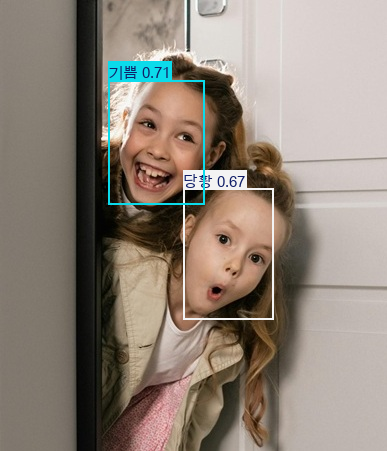

<Figure size 640x480 with 1 Axes>

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 2.], device='cuda:0')
conf: tensor([0.7126, 0.6683], device='cuda:0')
data: tensor([[108.8425,  80.3489, 204.4399, 204.4191,   0.7126,   1.0000],
        [183.9599, 188.2383, 273.2212, 319.4026,   0.6683,   2.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (451, 387)
shape: torch.Size([2, 6])
xywh: tensor([[156.6412, 142.3840,  95.5973, 124.0702],
        [228.5905, 253.8204,  89.2614, 131.1643]], device='cuda:0')
xywhn: tensor([[0.4048, 0.3157, 0.2470, 0.2751],
        [0.5907, 0.5628, 0.2306, 0.2908]], device='cuda:0')
xyxy: tensor([[108.8425,  80.3489, 204.4399, 204.4191],
        [183.9599, 188.2383, 273.2212, 319.4026]], device='cuda:0')
xyxyn: tensor([[0.2812, 0.1782, 0.5283, 0.4533],
        [0.4753, 0.4174, 0.7060, 0.7082]], device='cuda:0')


In [78]:
#확인

# 모델 로드
model_Y = YOLO("/workspace/yoons/runs/detect/train/weights/best.onnx")

# 예측할 이미지 경로
image_path = "/workspace/yoons/pexels-a-darmel-7642207sm_cr.jpg" #KakaoTalk_20250610_112232395.jpg" #

# 추론
results = model_Y(image_path)

# 결과 시각화 (matplotlib 사용)
results[0].show()  # YOLO 내부 show 함수
# 또는
img = Image.open(image_path)
plt.imshow(results[0].plot())  # bounding box 포함된 이미지
plt.axis('off')
plt.show()

# 결과 객체 확인
print(results[0].boxes)


In [ ]:
print(model.names)  # 예: {0: '분노', 1: '기쁨', 2: '당황', 3: '슬픔'}


{0: '분노', 1: '기쁨', 2: '당황', 3: '슬픔'}


In [ ]:
for box in results[0].boxes:
    cls_id = int(box.cls[0])  # 클래스 ID
    conf = float(box.conf[0])  # 신뢰도
    print(f"감정: {model.names[cls_id]}, 신뢰도: {conf:.2f}")


감정: 기쁨, 신뢰도: 0.47


In [ ]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.], device='cuda:0')
conf: tensor([0.4729], device='cuda:0')
data: tensor([[6.7043e+02, 5.7767e+01, 1.3307e+03, 9.8185e+02, 4.7286e-01, 1.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1080, 1920)
shape: torch.Size([1, 6])
xywh: tensor([[1000.5427,  519.8077,  660.2162,  924.0821]], device='cuda:0')
xywhn: tensor([[0.5211, 0.4813, 0.3439, 0.8556]], device='cuda:0')
xyxy: tensor([[ 670.4346,   57.7666, 1330.6508,  981.8487]], device='cuda:0')
xyxyn: tensor([[0.3492, 0.0535, 0.6930, 0.9091]], device='cuda:0')